In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from numpy import pi
from torch import sin, cos

import time

In [3]:
def batch_determinant(B):
    assert B.dim() == 3, f"Dim.shape should be (K, 2, 2), got {B.shape}"
    return B[:, 0, 0] * B[:, 1, 1] - B[:, 1, 0] * B[:, 0, 1]


def batch_trace(B):
    assert B.dim() == 3, f"Dim.shape should be (K, 2, 2), got {B.shape}"
    return B[:, 0, 0] + B[:, 1, 1]

In [4]:
class FourierLayer2D(nn.Module):
    def __init__(self, n, init_scale=0.):
        super(FourierLayer2D, self).__init__()
        
        # Basis Size related numbers
        self.nvec = torch.arange(1, n+1)
        self.n = n
        self.N = 2 * n**2 + n
        
        # Upsampler required in forward pass
        self.upsample = nn.Upsample(scale_factor=n, mode='nearest')
        
        
        # Create weight vector
        self.weights = torch.nn.Parameter(
            init_scale * torch.randn(2*self.N, requires_grad=True)
        )
        
        # Ensure positive determinant. 
        self.project()
    
    
    def forward(self, x):
        """Assumes input on form (K, 2)"""
        K = x.shape[0]
        n, N = self.n, self.N
        z = (x.view(K, 2, 1) * self.nvec)
        
        # Sine matrices
        S1 = torch.sin(pi * z)
        S2 = torch.sin(2 * pi * z)[:, (1, 0), :]
        
        # Cosine matrices
        C1 = torch.cos(pi * z)
        C2 = torch.cos(2 * pi * z)[:, (1, 0), :]
        
        # Tensor product matrices.
        T2 = self.upsample(S1) * S2.repeat(1, 1, n)
        T3 = self.upsample(S1) * C2.repeat(1, 1, n)

        # Function output tensor
        B = torch.zeros(K, 2, 2*N)

        B[:, 0, :n] = S1[:, 0, :]  # Type 1 x direction
        B[:, 1, N:(N+n)] = S1[:, 1, :]  # Type 1  y-direction

        B[:, 0, n:(n**2+n)] = T2[:, 0, :]  #Type 2 x-direction
        B[:, 1, (N+n):(N + n**2 + n)] = T2[:, 1, :]  # Type 2 y-direction

        B[:, 0, (n+n**2):N] = T3[:, 0, :]  # Type 3 x-direction
        B[:, 1, (N+n+n**2):] = T3[:, 1, :]  # Type3 y-direction
        
        
        
        # Now for derivative matrices
        T11 = self.upsample(self.nvec * pi * C1) * S2.repeat(1, 1, n)
        T12 = self.upsample(S1) * (2 * pi * self.nvec * C2).repeat(1, 1, n)
        
        T21 = self.upsample(self.nvec * pi * C1) * C2.repeat(1, 1, n)
        T22 = self.upsample(S1) * (-2 * pi * self.nvec * S2).repeat(1, 1, n)

        
        # Create and fill a tensor with derivative outputs
        D = torch.zeros(K, 2, 2, 2*N)

        D[:, 0, 0, :n] = self.nvec * pi * C1[:, 0, :]  # Type 1 x direction dx 
        D[:, 1, 1, N:(N+n)] = self.nvec * pi * C1[:, 1, :]  # Type 1  y-direction dy 

        
        D[:, 0, 0, n:(n + n**2)] = T11[:, 0, :] # Type 2 x-direction dx
        D[:, 0, 1, n:(n + n**2)] = T12[:, 0, :]  # Type 2 x-direction dy
        D[:, 1, 1, (N+n):(N + n + n**2)] = T11[:, 1, :]  # Type 2 y-direction dy
        D[:, 1, 0, (N+n):(N + n + n**2)] = T12[:, 1, :]  # Type 2 x-direction dy


        D[:, 0, 0, (n+n**2):N] = T21[:, 0, :]  # Type 3 x-direction dx 
        D[:, 0, 1, (n+n**2):N] = T22[:, 0, :]  # Type 3 x-direction dy

        D[:, 1, 1, (N+n+n**2):] = T21[:, 1, :]  # Type 3 y-direction dy
        D[:, 1, 0, (N+n+n**2):] = T22[:, 1, :]  # Type 3 y-direction dx 
        
        
        I = torch.eye(2).view(1, 2, 2).repeat(K, 1, 1)
        return x + (B @ self.weights), batch_determinant(I + D @ self.weights)
        
        
    def project(self):
        pass

In [5]:
class Surface(nn.Module):
    def __init__(self, component_function_tuple):
        super(Surface, self).__init__()
        self.S = tuple(component_function_tuple)
        
    def forward(self, X):
        return torch.cat([ci(X).unsqueeze(dim=-1) for ci in self.S], dim=-1)
    
    
    def partial_derivative(self, X, component, h=1e-3):
        H = torch.zeros_like(X)
        H[..., component] = h
        return 0.5 * torch.cat([(ci(X + H) - ci(X - H)).unsqueeze(dim=-1) for ci in self.S], dim=-1) / h 
    
    def volume_factor(self, X, h=1e-3):
        dfx = self.partial_derivative(X, 0, h)
        dfy = self.partial_derivative(X, 1, h)
        return torch.norm(torch.cross(dfx, dfy, dim=-1), dim=-1, keepdim=True)
    
    
    def compose(self, f):
        # TODO: Allow genereal dimension curves.
        return Surface((
            lambda x: self.S[0](f(x)),
            lambda x: self.S[1](f(x)),
            lambda x: self.S[2](f(x))
        ))
    
    
class Qmap(nn.Module):
    def __init__(self, surface: Surface):
        super(Qmap, self).__init__()
        self.s = surface
        
        
    def forward(self, X, h=1e-3):
        return torch.sqrt(self.s.volume_factor(X, h)) * self.s(X)
    
    
    
class Diffeomorphism(nn.Module):
    def __init__(self, component_function_tuple):
        super(Diffeomorphism, self).__init__()
        self.S = tuple(component_function_tuple)
        
    def forward(self, X):
        out = torch.zeros_like(X)
        out[..., 0] = self.S[0](X)
        out[..., 1] = self.S[1](X)

        return out

In [6]:
C = (
    lambda x: x[..., 0],
    lambda x: x[..., 1],
    lambda x: x[..., 0]**2 + x[..., 1]**2
)

f = Surface(C)
q = Qmap(f)
γ = Diffeomorphism((lambda x: x[..., 0], lambda x: 0.9*x[..., 1]**2 + 0.1 * x[..., 1]))

g = f.compose(γ)
r = Qmap(g)

In [7]:
def get_plot_data(f, k=32):
    K = k**2
    X = torch.rand(K, 2)
    
    X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
    X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
    
    X = torch.cat((X, Y), dim=1)
    
    Z = f(X).detach().numpy().T
    return Z.reshape(3, k, k)

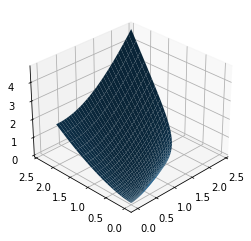

In [8]:
Z = get_plot_data(r)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(*Z)
ax.view_init(30, -135)

In [9]:
class ReparametrizationNetwork(nn.Module):
    def __init__(self, n, q:Qmap, r :Qmap):
        super(ReparametrizationNetwork, self).__init__()
        self.layer1 = FourierLayer2D(n)
        self.layer2 = FourierLayer2D(n)
        self.layer3 = FourierLayer2D(n)


        
        self.q = q
        self.r = r
        
    def forward(self, X):
        Z, J = self.layer1(X)
        Z, J2 = self.layer2(Z)
        J = J2 * J
        Z, J2 = self.layer3(Z)
        J = J2 * J
        Q = self.q(X)
        R = self.r(Z)
        
        return Q, R * torch.sqrt(J.view(-1, 1))

In [10]:
k = 32
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

# Instantiate a 2-layer network with 5 basis functions per layer.
RN = ReparametrizationNetwork(5, r, q)

In [11]:
# Choos update rule (here SGD with momentum)
optimizer = optim.SGD(RN.parameters(), lr=1e-3, momentum=0.5)
# optimizer = optim.Adam(RN.parameters(), lr=5e-5)


# Define MSE loss function (which coinsides with a scaled version of our solution) 
# NOTE: Not a complete 1-1 correspondence with the theory, but gives a simple starting point.
loss = nn.MSELoss()


tic = time.time()

k = 32
K = k**2
X = torch.rand(K, 2)
X, Y = torch.meshgrid((torch.linspace(0, 1, k), torch.linspace(0, 1, k)))
X, Y = X.reshape(-1, 1), Y.reshape(-1, 1)
X = torch.cat((X, Y), dim=1)

# Initialize node placement
for i in range(1000):    
    # Set gradient buffers to zero.
    optimizer.zero_grad()
    
    # Find current reparametrized Q-maps
    Q, R = RN(X)
    
    # Compute loss, and perform a backward pass and gradient step
    l = loss(Q, R)
    l.backward()
    optimizer.step()


    if i % 10 == 0:
        print('[Iter %5d] loss: %.5f' %
              (i + 1, l))
        
    # Should insert projection step here as well (has not been necessary until now)
            
toc = time.time()

print()
print(f'Finished training in {toc - tic:.5f}s')

[Iter     1] loss: 0.07726
[Iter    11] loss: 0.04216
[Iter    21] loss: 0.03033
[Iter    31] loss: 0.02274
[Iter    41] loss: 0.01733
[Iter    51] loss: 0.01335
[Iter    61] loss: 0.01039
[Iter    71] loss: 0.00818
[Iter    81] loss: 0.00653
[Iter    91] loss: 0.00529
[Iter   101] loss: 0.00435
[Iter   111] loss: 0.00363
[Iter   121] loss: 0.00308
[Iter   131] loss: 0.00265
[Iter   141] loss: 0.00232
[Iter   151] loss: 0.00205
[Iter   161] loss: 0.00183
[Iter   171] loss: 0.00166
[Iter   181] loss: 0.00151
[Iter   191] loss: 0.00139
[Iter   201] loss: 0.00129
[Iter   211] loss: 0.00120
[Iter   221] loss: 0.00113
[Iter   231] loss: 0.00106
[Iter   241] loss: 0.00100
[Iter   251] loss: 0.00095
[Iter   261] loss: 0.00090
[Iter   271] loss: 0.00085
[Iter   281] loss: 0.00082
[Iter   291] loss: 0.00078
[Iter   301] loss: 0.00075
[Iter   311] loss: 0.00071
[Iter   321] loss: 0.00069
[Iter   331] loss: 0.00066
[Iter   341] loss: 0.00063
[Iter   351] loss: 0.00061
[Iter   361] loss: 0.00059
[

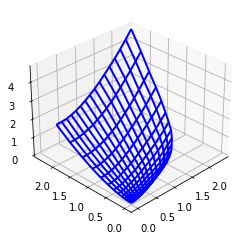

In [12]:
Zq = get_plot_data(q, k=16)
Zr = get_plot_data(r, k=16)
Zh = get_plot_data(lambda x: RN(x)[1], k=16)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.plot_wireframe(*Zq, color='r')
ax.plot_wireframe(*Zh, color='b', lw=2.)
# ax.plot_wireframe(*Zr, color='k')

ax.view_init(30, -135)